In [1]:
# H = T + H4(sqrt(alpha)*x)
# Basis: HO(omega_basis). Integrals via Gauss–Hermite with unweighted arrays.

import numpy as np
from numpy.linalg import eigh
from math import factorial, pi
import scipy.special as sp  # roots_hermite
import matplotlib.pyplot as plt

# Physicists' Hermite polynomial H_n(ξ) via numpy.polynomial.hermite.hermval
from numpy.polynomial.hermite import hermval


def He(n, xi):
    coeffs = np.zeros(n + 1)
    coeffs[-1] = 1.0
    return hermval(xi, coeffs)  # physicists' H_n


def Cn(n, alpha):
    # HO normalization for φ_n(x) = Cn * H_n(ξ) * e^{-ξ^2/2}, with ξ = sqrt(alpha) x
    return (alpha / pi) ** 0.25 / np.sqrt((2.0 ** n) * factorial(n))


def phi_unweighted(n, xi, alpha):
    # e^{-ξ^2/2} omitted (handled by GH weights); Φ_unw = Cn * H_n(ξ)
    return Cn(n, alpha) * He(n, xi)


def dphi_unweighted(n, xi, alpha):
    # derivative w.r.t x, but without the Gaussian factor (pairs with GH weights)
    # φ'_n(x) unweighted form: G_unw = Cn * sqrt(alpha) * [2n H_{n-1}(ξ) - ξ H_n(ξ)]
    if n == 0:
        return Cn(0, alpha) * np.sqrt(alpha) * (-xi * He(0, xi))
    return Cn(n, alpha) * np.sqrt(alpha) * (2.0 * n * He(n - 1, xi) - xi * He(n, xi))
r=np.linspace(-5,5,20)

In [2]:
def build_mats(N, nq, m=1.0, omega_basis=1.0, hbar=1.0):
    """
    Returns:
      T   = ⟨m| -(ħ²/2m) d²/dx² |n⟩ via gradient form
      X2  = ⟨m| x² |n⟩
      X4  = ⟨m| x⁴ |n⟩
      alpha = m*omega_basis/hbar
    """
    alpha = m * omega_basis / hbar
    xi, w = sp.roots_hermite(nq)  # ∫ g(ξ) e^{-ξ²} dξ ≈ Σ w_i g(ξ_i)
    dx_factor = 1.0 / np.sqrt(alpha)  # dx = dξ / sqrt(alpha)

    # Unweighted basis arrays evaluated on GH nodes
    Phi = np.array([phi_unweighted(n, xi, alpha) for n in range(N)])
    dPhi = np.array([dphi_unweighted(n, xi, alpha) for n in range(N)])

    # x = ξ / sqrt(alpha)  → x² = ξ²/alpha, x⁴ = ξ⁴/alpha²
    X2 = (Phi @ np.diag(w * (xi ** 2 / alpha)) @ Phi.T) * dx_factor
    X4 = (Phi @ np.diag(w * ((xi ** 4) / alpha ** 2)) @ Phi.T) * dx_factor

    # Kinetic via gradient form: T_mn = (ħ²/2m) ∫ (∂x φ_m)(∂x φ_n) dx
    prefT = (hbar * hbar) / (2.0 * m)
    T = prefT * (dPhi @ np.diag(w) @ dPhi.T) * dx_factor

    # Symmetrize (remove tiny float asymmetries)
    T = 0.5 * (T + T.T)
    X2 = 0.5 * (X2 + X2.T)
    X4 = 0.5 * (X4 + X4.T)

    return T, X2, X4, alpha

In [3]:
def H4_operator_from_X(X2, X4, alpha, N, lam=1.0):
    """
    H4(√α x) as a matrix in HO basis.
    Using H4(ξ) = 16 ξ^4 - 48 ξ^2 + 12, with ξ = √α x.
      ⇒ H4(√α x) = 16 α² x⁴ - 48 α x² + 12 I.
    """
    I = np.eye(N)
    V_H4 = 16.0 * (alpha ** 2) * X4 - 48.0 * alpha * X2 + 12.0 * I
    return Cn(4, alpha) *lam * V_H4

In [4]:
def solve_H4(N=60, nq=None, m=1.0, omega_phys=1.0, omega_basis=None, hbar=1.0, lam=1.0):
    """
    Constructs H = T + H4(√α x) in the HO(omega_basis) basis and diagonalizes it.
    By default, omega_basis = omega_phys (good, stable choice).
    """
    if omega_basis is None:
        omega_basis = omega_phys
    if nq is None:
        nq = max(2 * N + 20, 80)  # safe default

    T, X2, X4, alpha = build_mats(N, nq, m=m, omega_basis=omega_basis, hbar=hbar)
    V_H4 = H4_operator_from_X(X2, X4, alpha, N, lam=lam)
    H = T + V_H4

    E, Vvecs = eigh(H)  # columns are eigenvectors
    return E, Vvecs, H, T, V_H4, X2, X4, alpha

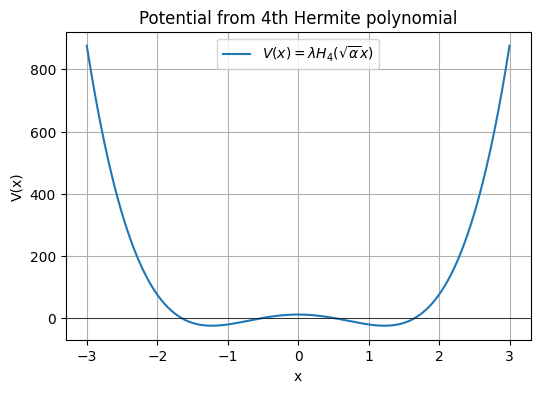

In [5]:
def plot_V(alpha, lam=1.0, x_range=(-3, 3), n_points=400):
    """
    Plot the potential term V(x) = λ H4(√α x).
    """
    x = np.linspace(x_range[0], x_range[1], n_points)
    xi = (np.sqrt(alpha) * x)

    # Physicists' Hermite polynomial H4(ξ) = 16ξ^4 - 48ξ^2 + 12
    H4 = 16 * xi ** 4 - 48 * xi ** 2 + 12
    V = lam * H4

    plt.figure(figsize=(6, 4))
    plt.plot(x, V, label=r"$V(x) = \lambda H_4(\sqrt{\alpha}x)$")
    plt.axhline(0, color="k", linewidth=0.5)
    plt.xlabel("x")
    plt.ylabel("V(x)")
    plt.title("Potential from 4th Hermite polynomial")
    plt.legend()
    plt.grid(True)
    plt.show()


# Example usage:
T, X2, X4, alpha = build_mats(N=60, nq=120, m=1.0, omega_basis=1.0, hbar=1.0)
plot_V(alpha, lam=1)

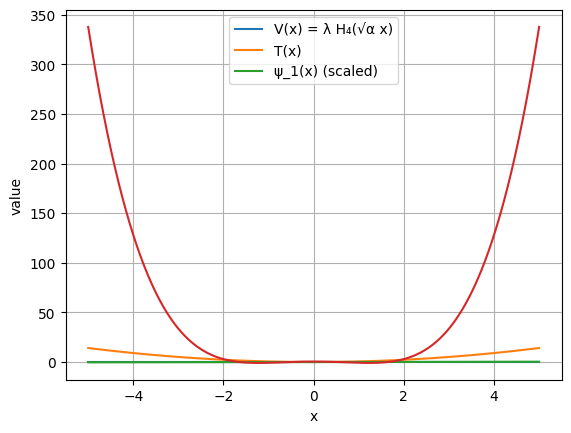

[0.00766283 0.03027804 0.068983   0.1211572  0.19171692]
[-1.72219930e-13  1.77925481e-01 -1.16069062e-13  2.09116003e-01
 -9.58178091e-14  2.24201344e-01 -8.31582063e-14  2.32051573e-01
 -7.37618974e-14  2.35664378e-01 -6.63383697e-14  2.36464297e-01
 -6.00707286e-14  2.35257985e-01 -5.48996549e-14  2.32554499e-01
 -5.01111489e-14  2.28699707e-01 -4.58360548e-14  2.23941501e-01]


In [9]:
# Minimal: plot V(x) = λ H4(√α x) and eigenstate ψ_k(x) for k=4
# Assumes solve_H4, He, Cn, numpy as np, and matplotlib.pyplot as plt are already defined/imported.

k = 1
lam = 0
N = 80
nq = max(2 * N + 20, 80)

# Solve H = T + λ H4(√α x)
E, Vvecs, H, T, V_H4, X2, X4, alpha = solve_H4(N=N, nq=nq, m=1.0, omega_phys=1.0, omega_basis=1.0, hbar=1.0, lam=lam)

# Real-space grid
x = np.linspace(-5, 5, 600)
xi = np.sqrt(alpha) * x

# Potential V(x) = λ H4(√α x) with H4(ξ) = 16ξ^4 − 48ξ^2 + 12
Vx = Cn(4, alpha) *lam * (16 * xi ** 4 - 48 * xi ** 2 + 12)
T=dphi_unweighted(0, xi, alpha)*dphi_unweighted(0, xi, alpha)
# Build HO basis on the grid and reconstruct ψ_k(x)
phis = np.array([Cn(n, alpha) * He(n, xi) * np.exp(-xi ** 2 / 2) for n in range(Vvecs.shape[0])])
psi_k = Vvecs[:, k] @ phis
phi_4= Cn(4, alpha) *He(4, xi) #* np.exp(-xi ** 2 / 2)
# Scale ψ_k for visibility on the same axis
range_V = Vx.max() - Vx.min()
if range_V == 0:
    range_V = 1.0
psi_scale = 0.3 * range_V / (np.max(np.abs(psi_k)) + 1e-12)

# Plot
plt.figure()
plt.plot(x, Vx, label='V(x) = λ H₄(√α x)')
plt.plot(x,T,label='T(x)')
plt.plot(x, psi_scale * psi_k, label=f'ψ_{k}(x) (scaled)')
plt.plot(x, phi_4)
plt.xlabel('x')
plt.ylabel('value')
plt.legend()
plt.grid(True)
plt.show()

print(E[:5])
print(Vvecs[:20, k])

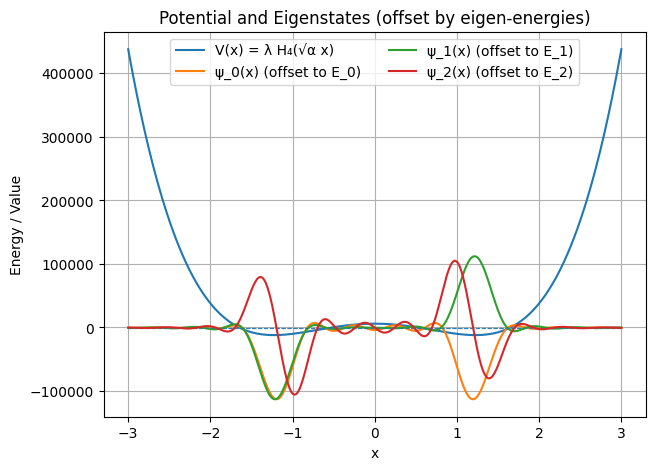

In [7]:
# Plot V(x) = λ H4(√α x) and eigenstates ψ_k(x) for k = 0..4,
# each eigenstate vertically offset to its energy E_k.

lam = 500
N = 80
nq = max(2 * N + 20, 80)

# Solve H = T + λ H4(√α x)
E, Vvecs, H, T, V_H4, X2, X4, alpha = solve_H4(
    N=N, nq=nq, m=1.0, omega_phys=1.0, omega_basis=1.0, hbar=1.0, lam=lam
)

# Grid and potential
x = np.linspace(-3, 3, 600)
xi = np.sqrt(alpha) * x
Vx = lam * (16 * xi ** 4 - 48 * xi ** 2 + 12)

# Build HO basis on the grid
phis = np.array([Cn(n, alpha) * He(n, xi) * np.exp(-xi ** 2 / 2) for n in range(Vvecs.shape[0])])

# Reconstruct ψ_k(x) for k = 0..4
psis = np.array([Vvecs[:, k] @ phis for k in range(5)])

# Choose a common scale so wavefunctions are visible but not overwhelming
range_V = Vx.max() - Vx.min()
max_psi = np.max(np.abs(psis))
scale = (0.25 * range_V) / (max_psi + 1e-12)

plt.figure(figsize=(7, 5))
plt.plot(x, Vx, label='V(x) = λ H₄(√α x)')

# Plot each eigenstate offset by its energy, with an energy line
for k in range(3):
    plt.hlines(E[k], x[0], x[-1], linestyles='--', linewidth=0.8, alpha=0.6)
    plt.plot(x, E[k] + scale * psis[k], label=f'ψ_{k}(x) (offset to E_{k})')

plt.xlabel('x')
plt.ylabel('Energy / Value')
plt.legend(loc='best', ncol=2)
plt.grid(True)
plt.title('Potential and Eigenstates (offset by eigen-energies)')
plt.show()

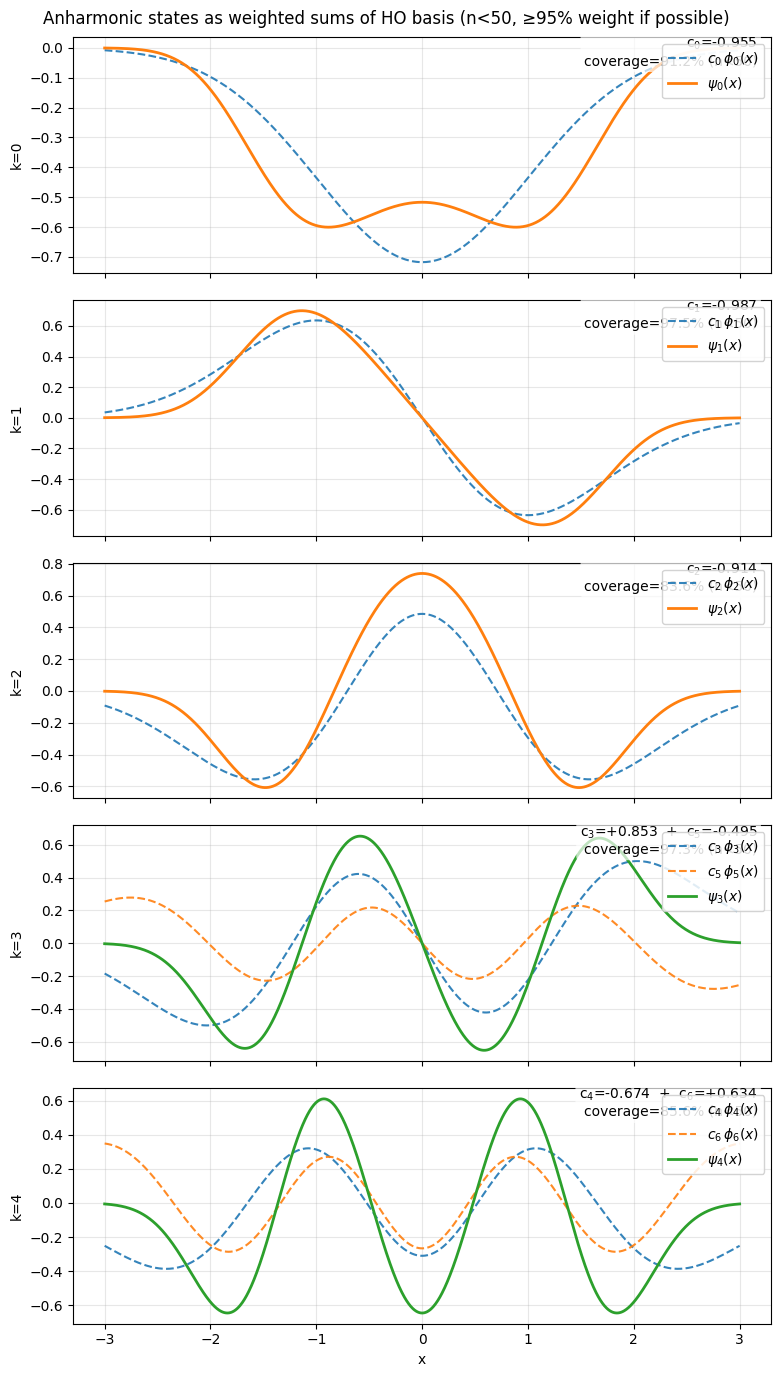

In [8]:
# Five stacked graphs: for each ψ_k(x), show only those HO components among n<50
# whose cumulative weight (sum of |c_n|^2 over ALL n) reaches ~95%.
# If the first 50 cannot reach 95%, the achieved coverage is shown.

# Solve (re-uses current lam, N if present)
lam = 1
N = locals().get('N', 80)
nq = max(2 * N + 20, 80)
E, Vvecs, H, T, V_H4, X2, X4, alpha = solve_H4(
    N=N, nq=nq, m=1.0, omega_phys=1.0, omega_basis=1.0, hbar=1.0, lam=lam
)

# Grid & HO basis
x = np.linspace(-3, 3, 1200)
xi = np.sqrt(alpha) * x
phis = np.array([Cn(n, alpha) * He(n, xi) * np.exp(-xi ** 2 / 2) for n in range(Vvecs.shape[0])])


def select_indices_95(c, max_n=50):
    """Return indices within [0, max_n) whose |c_n|^2 cover ≥95% of total ∑|c|^2 (if possible)."""
    full_total = float(np.sum(c ** 2)) + 1e-16
    pool = np.arange(min(max_n, c.size))
    w = (c[pool] ** 2)
    order = np.argsort(w)[::-1]
    sel = []
    cum = 0.0
    for j in order:
        sel.append(int(pool[j]))
        cum += float(w[j])
        if cum / full_total >= 0.80:
            break
    coverage = cum / full_total
    return sel, coverage


# Figure
fig, axes = plt.subplots(5, 1, figsize=(8, 14), sharex=True)
fig.suptitle(r"Anharmonic states as weighted sums of HO basis (n<50, ≥95% weight if possible)", y=0.98)

psis = [Vvecs[:, k] @ phis for k in range(5)]

for k, ax in enumerate(axes):
    c = Vvecs[:, k]
    psi = psis[k]

    keep, cov = select_indices_95(c, max_n=50)

    # Plot selected weighted components
    for n in keep:
        ax.plot(x, c[n] * phis[n], '--', alpha=0.9, label=rf"$c_{n}\,\phi_{n}(x)$")

    # Plot ψ_k
    ax.plot(x, psi, lw=2, label=rf"$\psi_{{{k}}}(x)$")

    ax.set_ylabel(f"k={k}")
    ax.grid(True, alpha=0.3)

    # Annotate coefficients and achieved coverage
    coeff_text = "  +  ".join([f"c$_{{{n}}}$={c[n]:+0.3f}" for n in keep])
    txt = (coeff_text + f"\ncoverage={cov * 100:.1f}% (n<50)").strip()
    ax.text(0.98, 0.88, txt, transform=ax.transAxes, ha='right',
            bbox=dict(boxstyle='round,pad=0.25', fc='white', ec='none', alpha=0.7))

    ax.legend(loc='upper right', framealpha=0.85)

axes[-1].set_xlabel("x")
plt.tight_layout()
plt.show()